In [1]:
# import packages
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import GridSearchCV

# for scaling
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Read the cleaned data file
df1 = pd.read_csv('v2_cleaned_Turbine_data.csv')
df1

,Unnamed: 0,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
0,2018-01-01 06:20:00+00:00,26.212347,28.696304,42.921070,0.390534,0.885209,0.885209,64.843517,57.189826,1123.212640,65.733543,64.944908,37.003815,39.500000,252.00,3.976499,10.086061,2.0,252.00,3.042750
1,2018-01-01 06:40:00+00:00,59.632658,29.052567,42.921070,0.390534,0.885209,0.885209,64.843517,57.189826,1123.212640,65.733543,64.944908,37.003815,39.500000,255.00,11.091660,10.086061,2.0,255.00,3.424814
2,2018-01-01 06:50:00+00:00,40.889650,28.984758,42.921070,0.390534,0.885209,0.885209,64.843517,57.189826,1123.212640,65.733543,64.944908,37.003815,39.500000,264.75,4.234497,10.086061,2.0,264.75,3.507172
3,2018-01-01 10:40:00+00:00,34.398111,30.282058,42.921070,0.390534,0.885209,0.885209,64.843517,57.189826,1123.212640,65.733543,64.944908,37.003815,39.500000,283.75,5.347792,10.086061,2.0,283.75,3.442212
4,2018-01-01 12:00:00+00:00,29.797653,29.333519,42.921070,0.390534,0.885209,0.885209,64.843517,57.189826,1123.212640,65.733543,64.944908,37.003815,39.500000,274.00,6.022326,10.086061,2.0,274.00,3.031363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78676,2020-03-30 23:10:00+00:00,70.044465,27.523741,45.711129,1.515669,1.950088,1.950088,59.821165,55.193793,1029.870744,59.060367,58.148777,39.008931,36.476562,178.00,13.775785,9.234004,2.0,178.00,3.533445
78677,2020-03-30 23:20:00+00:00,40.833474,27.602882,45.598573,1.702809,2.136732,2.136732,59.142038,54.798545,1030.160478,58.452003,57.550367,39.006759,36.328125,178.00,8.088928,9.229370,2.0,178.00,3.261231
78678,2020-03-30 23:30:00+00:00,20.777790,27.560925,45.462045,1.706214,2.139664,2.139664,58.439439,54.380456,1030.137822,58.034071,57.099335,39.003815,36.131944,178.00,4.355978,9.236802,2.0,178.00,3.331839
78679,2020-03-30 23:40:00+00:00,62.091039,27.810472,45.343827,1.575352,2.009781,2.009781,58.205413,54.079014,1030.178178,57.795387,56.847239,39.003815,36.007805,190.00,12.018077,9.237374,2.0,190.00,3.284468


In [3]:
df1.rename(columns = {'Unnamed: 0':'timestamp'}, inplace = True)
df1['timestamp'] = pd.to_datetime(df1['timestamp'])

In [4]:
df1['year']   = df1['timestamp'].dt.year
df1['month']  = df1['timestamp'].dt.month
df1['YearMonth'] = df1['timestamp'].apply(lambda x: x.strftime("%Y-%m"))
df1['day']    = df1['timestamp'].dt.day
df1['hour']   = df1['timestamp'].dt.hour
df1['minute'] = df1['timestamp'].dt.minute
df1['YearMonthDay'] = df1['timestamp'].apply(lambda x: x.strftime("%Y-%m-%d"))
df1.set_index('timestamp')

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,...,TurbineStatus,WindDirection,WindSpeed,year,month,YearMonth,day,hour,minute,YearMonthDay
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 06:20:00+00:00,26.212347,28.696304,42.921070,0.390534,0.885209,0.885209,64.843517,57.189826,1123.212640,65.733543,...,2.0,252.00,3.042750,2018,1,2018-01,1,6,20,2018-01-01
2018-01-01 06:40:00+00:00,59.632658,29.052567,42.921070,0.390534,0.885209,0.885209,64.843517,57.189826,1123.212640,65.733543,...,2.0,255.00,3.424814,2018,1,2018-01,1,6,40,2018-01-01
2018-01-01 06:50:00+00:00,40.889650,28.984758,42.921070,0.390534,0.885209,0.885209,64.843517,57.189826,1123.212640,65.733543,...,2.0,264.75,3.507172,2018,1,2018-01,1,6,50,2018-01-01
2018-01-01 10:40:00+00:00,34.398111,30.282058,42.921070,0.390534,0.885209,0.885209,64.843517,57.189826,1123.212640,65.733543,...,2.0,283.75,3.442212,2018,1,2018-01,1,10,40,2018-01-01
2018-01-01 12:00:00+00:00,29.797653,29.333519,42.921070,0.390534,0.885209,0.885209,64.843517,57.189826,1123.212640,65.733543,...,2.0,274.00,3.031363,2018,1,2018-01,1,12,0,2018-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-30 23:10:00+00:00,70.044465,27.523741,45.711129,1.515669,1.950088,1.950088,59.821165,55.193793,1029.870744,59.060367,...,2.0,178.00,3.533445,2020,3,2020-03,30,23,10,2020-03-30
2020-03-30 23:20:00+00:00,40.833474,27.602882,45.598573,1.702809,2.136732,2.136732,59.142038,54.798545,1030.160478,58.452003,...,2.0,178.00,3.261231,2020,3,2020-03,30,23,20,2020-03-30
2020-03-30 23:30:00+00:00,20.777790,27.560925,45.462045,1.706214,2.139664,2.139664,58.439439,54.380456,1030.137822,58.034071,...,2.0,178.00,3.331839,2020,3,2020-03,30,23,30,2020-03-30


### Separate into X, y

In [5]:
X_train, X_test, y_train,y_test = df1[['WindSpeed']][68025:78174], df1[['WindSpeed']][78316:78563], df1[['ActivePower']][68025:78174], df1[['ActivePower']][78316:78563]
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((10149, 1), (247, 1), (10149, 1), (247, 1))

### Build Model without hyperparameter tuning

In [6]:
rf = RandomForestRegressor()

In [7]:
# Fit the model to the training data 
rf.fit(X_train, y_train)

# Make the predictions
pred = rf.predict(X_test)
df_pred = pd.DataFrame(data={'Actuals':y_test['ActivePower'], 'Predictions':pred}, index=y_test.index)
df_pred['YearMonthDay'] = df1['YearMonthDay']

C:\Users\jhh\AppData\Local\Temp/ipykernel_3400/3585936913.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


In [8]:
df_pred.set_index('YearMonthDay')

,Actuals,Predictions
YearMonthDay,,
2020-03-28,150.649356,196.661896
2020-03-28,153.689721,178.610874
2020-03-28,157.681078,166.513014
2020-03-28,184.165438,180.499377
2020-03-28,122.418648,103.518390
...,...,...
2020-03-29,13.904981,37.950510
2020-03-29,36.874418,48.401559
2020-03-30,106.387972,82.614750


In [9]:
r2 = r2_score(df_pred['Actuals'],df_pred['Predictions'])
mae = mean_absolute_error(df_pred['Actuals'],df_pred['Predictions'])
rmse = mean_squared_error(df_pred['Actuals'],df_pred['Predictions'],squared=False)

print('The Coefficient of determination (R-squared) = {:.3f}'.format(r2))
print('The mean absolute error (MAE)                = {:.2f}'.format(mae))
print('The root mean squared error (RMSE)           = {:.2f}'.format(rmse))

The Coefficient of determination (R-squared) = 0.960
The mean absolute error (MAE)                = 78.96
The root mean squared error (RMSE)           = 111.85


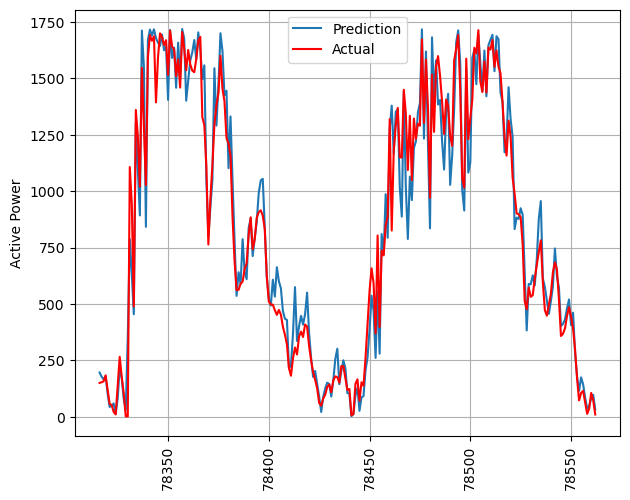

In [32]:
# plot
plt.plot(df_pred['Predictions'],label='Prediction')
plt.plot(df_pred['Actuals'], color='red',label='Actual')

plt.ylabel('Active Power')
plt.legend()
plt.tight_layout()
plt.xticks(rotation = 90) 
plt.grid()
plt.show()

### Hyperparameter Tuning 1

In [11]:
#set parameters
params_rf = {'max_depth': [5, 50, 500], 
             'min_samples_leaf': [0.1,0.2], 
             'max_features': ['log2', 'sqrt', 'auto'],
             'n_estimators':[50,100,200,300,400,500]}

grid_rf = GridSearchCV(estimator = rf,
                      param_grid = params_rf,
                      scoring = 'r2',
                      verbose = 1,
                        cv = 5,
                      n_jobs =-1)

In [12]:
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


C:\Users\jhh\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 50, 500],
                         'max_features': ['log2', 'sqrt', 'auto'],
                         'min_samples_leaf': [0.1, 0.2],
                         'n_estimators': [50, 100, 200, 300, 400, 500]},
             scoring='r2', verbose=1)

In [13]:
best_hyperparams = grid_rf.best_params_ 
print('Best hyerparameters:\n', best_hyperparams)

Best hyerparameters:
 {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'n_estimators': 50}


In [14]:
y_pred = grid_rf.predict(X_test)

In [15]:
best_rf = grid_rf.best_estimator_
pred = best_rf.predict(X_test)

df_final = pd.DataFrame(data={'Actuals':y_test['ActivePower'], 'Predictions':pred}, index=y_test.index)

In [16]:
df_final['YearMonthDay'] = df1['YearMonthDay']
df_final.set_index('YearMonthDay')

,Actuals,Predictions
YearMonthDay,,
2020-03-28,150.649356,185.592352
2020-03-28,153.689721,241.670453
2020-03-28,157.681078,227.590013
2020-03-28,184.165438,131.016964
2020-03-28,122.418648,79.810273
...,...,...
2020-03-29,13.904981,79.810273
2020-03-29,36.874418,79.810273
2020-03-30,106.387972,95.806526


In [17]:
hp_r2 = r2_score(df_final['Actuals'],df_final['Predictions'])
hp_mae = mean_absolute_error(df_final['Actuals'],df_final['Predictions'])
hp_rmse = mean_squared_error(df_final['Actuals'],df_final['Predictions'],squared=False)

print('The Coefficient of determination (R-squared) = {:.3f}'.format(hp_r2))
print('The mean absolute error (MAE)                = {:.2f}'.format(hp_mae))
print('The RMSE error (RMSE)                        = {:.2f}'.format(hp_rmse))

The Coefficient of determination (R-squared) = 0.929
The mean absolute error (MAE)                = 117.78
The RMSE error (RMSE)                        = 149.50


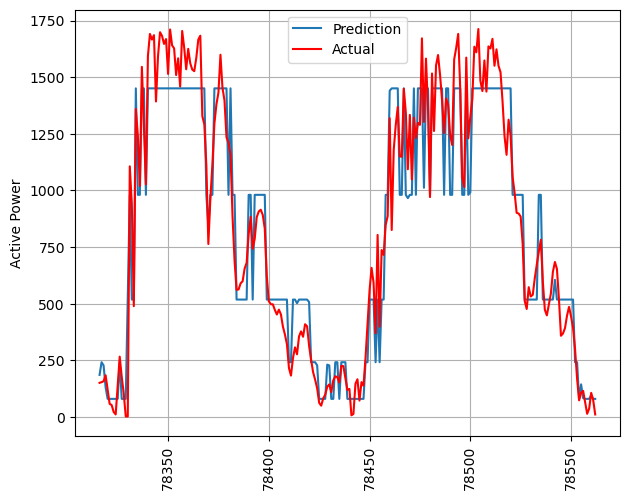

In [18]:
# plot
plt.plot(df_final['Predictions'],label='Prediction')
plt.plot(df_final['Actuals'], color='red',label='Actual')

plt.ylabel('Active Power')
plt.legend()
plt.tight_layout()
plt.grid()
plt.xticks(rotation = 90)
plt.show()

### Hyperparameter Tuning 2

In [19]:
#set parameters
params_rf2 = {'max_depth': [4, 6, 8], 
             'min_samples_leaf': [0.1, 2],
             'max_features': ['sqrt', 'auto'],
             'n_estimators' : [1, 600, 1200]}

grid_rf2 = GridSearchCV(estimator=rf, param_grid=params_rf2, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

In [20]:
grid_rf2.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


C:\Users\jhh\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\jhh\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8],
                         'max_features': ['sqrt', 'auto'],
                         'min_samples_leaf': [0.1, 2],
                         'n_estimators': [1, 600, 1200]},
             scoring='neg_mean_squared_error', verbose=1)

In [21]:
best_hyperparams2 = grid_rf2.best_params_ 
print('Best hyerparameters:\n', best_hyperparams2)

Best hyerparameters:
 {'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 1200}


In [22]:
y_pred = grid_rf2.predict(X_test)

In [23]:
# Use the best hyperparameters to make predictions on the test set
best_rf2 = grid_rf2.best_estimator_
hp2_pred = best_rf2.predict(X_test)

df_final = pd.DataFrame(data={'Actuals':y_test['ActivePower'], 'Predictions':hp2_pred}, index=y_test.index)

In [24]:
df_final['YearMonthDay'] = df1['YearMonthDay']
df_final.set_index('YearMonthDay')

,Actuals,Predictions
YearMonthDay,,
2020-03-28,150.649356,166.026125
2020-03-28,153.689721,196.692031
2020-03-28,157.681078,172.863070
2020-03-28,184.165438,155.533266
2020-03-28,122.418648,115.155018
...,...,...
2020-03-29,13.904981,36.077005
2020-03-29,36.874418,51.691490
2020-03-30,106.387972,150.333840


In [25]:
hp2_r2 = r2_score(df_final['Actuals'],df_final['Predictions'])
hp2_mae = mean_absolute_error(df_final['Actuals'],df_final['Predictions'])
hp2_rmse = mean_squared_error(df_final['Actuals'],df_final['Predictions'],squared=False)

print('The Coefficient of determination (R-squared) = {:.3f}'.format(hp2_r2))
print('The mean absolute error (MAE)                = {:.2f}'.format(hp2_mae))
print('The RMSE error (RMSE)                        = {:.2f}'.format(hp2_rmse))

The Coefficient of determination (R-squared) = 0.967
The mean absolute error (MAE)                = 71.19
The RMSE error (RMSE)                        = 102.13


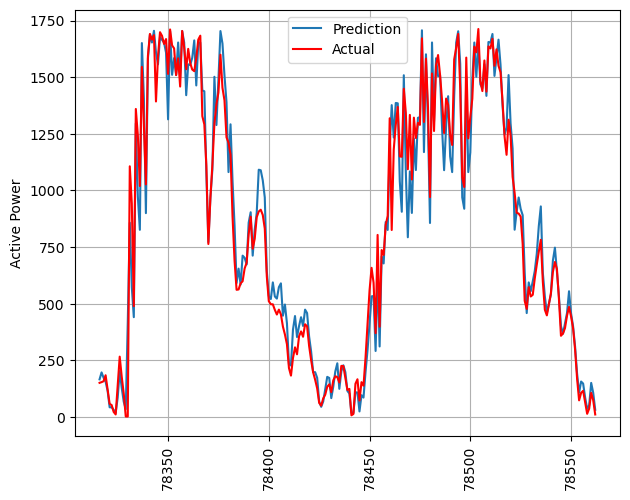

In [26]:
# plot
plt.plot(df_final['Predictions'],label='Prediction')
plt.plot(df_final['Actuals'], color='red',label='Actual')

plt.ylabel('Active Power')
plt.legend()
plt.tight_layout()
plt.grid()
plt.xticks(rotation = 90)
plt.show()

## Comparison on models

In [27]:
results_r2 = [round(r2, 2), round(hp_r2, 2), round(hp2_r2, 2)]
results_mae = [round(mae, 2), round(hp_mae, 2), round(hp2_mae, 2)]
results_rmse = [round(rmse,2), round(hp_rmse, 2), round(hp2_rmse, 2)]

print('r2: ', results_r2)
print('mae: ', results_mae)
print('rmse: ', results_rmse)

r2:  [0.96, 0.93, 0.97]
mae:  [78.96, 117.78, 71.19]
rmse:  [111.85, 149.5, 102.13]


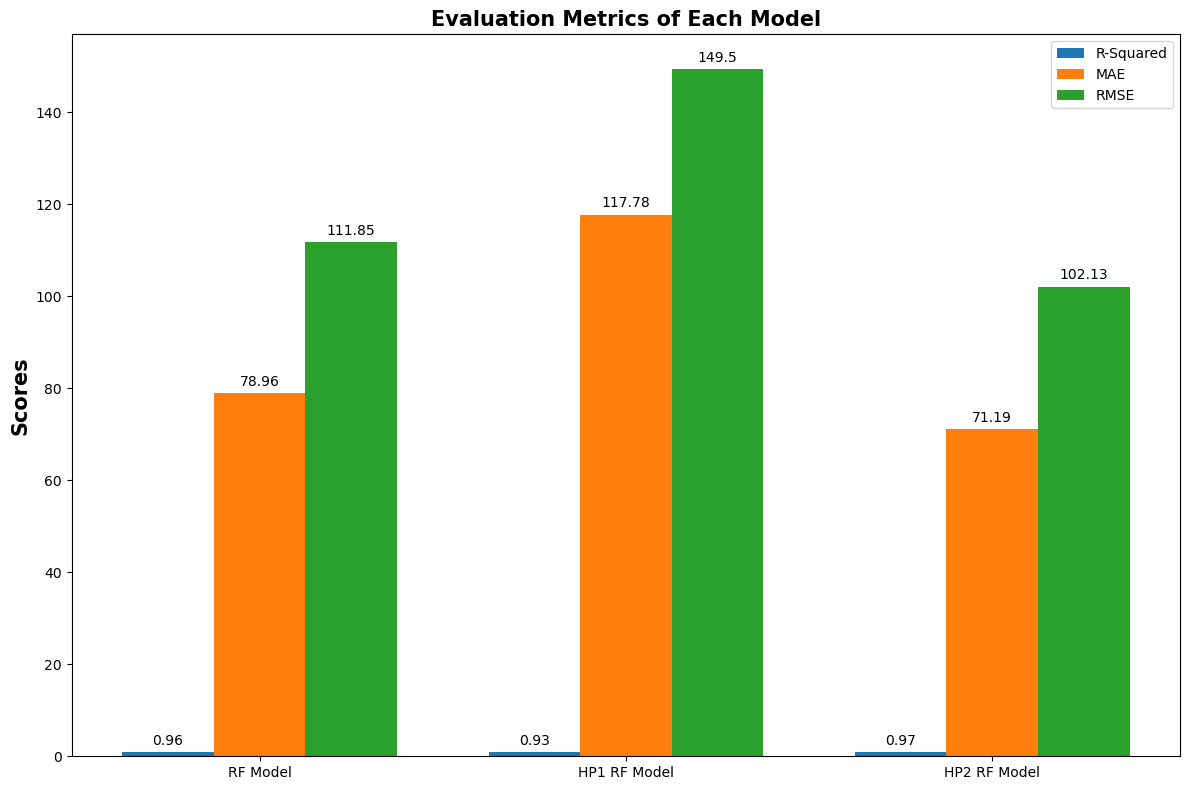

In [28]:
labels = ['RF Model','HP1 RF Model','HP2 RF Model']
barWidth = 0.25  
br1 = np.arange(len(labels))  
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

fig, ax = plt.subplots(figsize =(12, 8))
rects1 = ax.bar(br1, results_r2, barWidth, label='R-Squared')
rects2 = ax.bar(br2, results_mae, barWidth, label='MAE')
rects3 = ax.bar(br3, results_rmse, barWidth, label='RMSE')

ax.set_ylabel('Scores', fontweight ='bold', fontsize = 15)
ax.set_title('Evaluation Metrics of Each Model', fontweight ='bold', fontsize = 15)
ax.set_xticks([r + barWidth for r in range(len(labels))], labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()